In [1]:
import sys
sys.path.append('../input/timm-pytorch-image-models/pytorch-image-models-master')
sys.path.append('../input/pytorch-optimizers/')

In [2]:
import os
import gc
import cv2
import copy
import time
import yaml
import random
import shutil
import warnings
import subprocess
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from glob import glob
from tqdm import tqdm
from PIL import Image, ImageDraw
from shutil import copyfile
from IPython.core.display import Video, display
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, KFold, GroupKFold, StratifiedKFold

import timm
import torch
import torch.nn.functional as F
import torchvision
from torch import nn
from torch.cuda.amp import autocast, GradScaler
from torch.utils.data import Dataset,DataLoader
from torch.utils.data.sampler import SequentialSampler, RandomSampler
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.nn.modules.loss import _WeightedLoss
from torchvision import models, transforms
from torch_optimizer.radam import RAdam

from albumentations.pytorch import ToTensorV2
from albumentations import (
    HorizontalFlip, VerticalFlip, IAAPerspective, ShiftScaleRotate, CLAHE, RandomRotate90,
    Transpose, ShiftScaleRotate, Blur, OpticalDistortion, GridDistortion, HueSaturationValue,
    IAAAdditiveGaussianNoise, GaussNoise, MotionBlur, MedianBlur, IAAPiecewiseAffine, RandomResizedCrop,
    IAASharpen, IAAEmboss, RandomBrightnessContrast, Flip, OneOf, Compose, Normalize, Cutout, CoarseDropout,
    ShiftScaleRotate, CenterCrop, Resize, Rotate, RandomRotate90, RGBShift, ChannelShuffle)

warnings.simplefilter('ignore')
pd.set_option("max_columns", 150)
pd.set_option('display.max_rows', 150)

# Configuration

In [3]:
CFG = {
    "save_prev"   : [True, ["petfinder_*_type2_*.pt", ]],
    "train_type"  : 2,
    "seed"        : 42,
    'device'      : "cuda:0" if torch.cuda.is_available() else "cpu",
    "input_trimg" : '../input/petfinder-pawpularity-score/train/',
    "input_trpath": '../input/petfinder-smogn-dataset/train_drop_duplicated.csv',
    "input_eximg" : '../input/petfinder-adoption-prediction/train_images/',
    "input_expath": '../input/petfinder-pseudolabel-dataset/train.csv',
    "output_path" : './',
    "save_name"   : "petfinder_efnet_binary_ss_type2",
    "model"       : "tf_efficientnetv2_s_in21k",
    "loss"        : "binary",
    "size"        : 224,
    "fold"        : 4,
    "break_fold"  : 99,
    "batch_size"  : 32,
    "epochs"      : 10,
    "mixup_ratio" : 0,
    'T_0'         : 20,
    "lr"          : 2e-5,
    'momentum'    : 0.9,
    'weight_decay': 1e-4,
    "accum_iter"  : 2,
    'early_stopping': 10,
    'verbose_step'  : 1,
    "num_workers"   : 4
}

CFG

{'save_prev': [True, ['petfinder_*_type2_*.pt']],
 'train_type': 2,
 'seed': 42,
 'device': 'cuda:0',
 'input_trimg': '../input/petfinder-pawpularity-score/train/',
 'input_trpath': '../input/petfinder-smogn-dataset/train_drop_duplicated.csv',
 'input_eximg': '../input/petfinder-adoption-prediction/train_images/',
 'input_expath': '../input/petfinder-pseudolabel-dataset/train.csv',
 'output_path': './',
 'save_name': 'petfinder_efnet_binary_ss_type2',
 'model': 'tf_efficientnetv2_s_in21k',
 'loss': 'binary',
 'size': 224,
 'fold': 4,
 'break_fold': 99,
 'batch_size': 32,
 'epochs': 10,
 'mixup_ratio': 0,
 'T_0': 20,
 'lr': 2e-05,
 'momentum': 0.9,
 'weight_decay': 0.0001,
 'accum_iter': 2,
 'early_stopping': 10,
 'verbose_step': 1,
 'num_workers': 4}

In [4]:
def get_img(path):
    im_bgr = cv2.imread(path)
    im_rgb = im_bgr[:, :, ::-1]
    return im_rgb

def sigmoid(a):
    return 1 / (1 + np.exp(-a))

def softmax(x):
    max = np.max(x,axis=1,keepdims=True)
    e_x = np.exp(x - max)
    sum = np.sum(e_x,axis=1,keepdims=True)
    return e_x / sum 

def seed_everything(seed = 42):
    '''Sets the seed of the entire notebook so results are the same every time we run.
    This is for REPRODUCIBILITY.'''
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    # When running on the CuDNN backend, two further options must be set
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    # Set a fixed value for the hash seed
    os.environ['PYTHONHASHSEED'] = str(seed)
    
seed_everything(CFG["seed"])

In [5]:
if CFG['save_prev'][0]:
    for file_pattern in CFG['save_prev'][1]:
        for f in glob(f"../input/petfinder-semisupervised-models/{file_pattern}"):
            filename = os.path.basename(f)
            !cp {f} ./{filename}

# Load data

In [6]:
df_train = pd.read_csv(CFG['input_trpath'])
df_train["path"] = [f"{CFG['input_trimg']}{i}.jpg" for i in df_train.Id]
df_train["Pawclass"] = df_train.Pawpularity / 100

df_exdata = pd.read_csv(CFG['input_expath'])
df_exdata["Pawclass"] = df_exdata.Pawpularity / 100

print(df_train.shape, df_exdata.shape)
display(df_train.head(2))
display(df_exdata.head(2))

(9860, 16) (25000, 3)


,Id,Subject Focus,Eyes,Face,Near,Action,Accessory,Group,Collage,Human,Occlusion,Info,Blur,Pawpularity,path,Pawclass
0,0007de18844b0dbbb5e1f607da0606e0,0,1,1,1,0,0,1,0,0,0,0,0,63,../input/petfinder-pawpularity-score/train/000...,0.63
1,0009c66b9439883ba2750fb825e1d7db,0,1,1,0,0,0,0,0,0,0,0,0,42,../input/petfinder-pawpularity-score/train/000...,0.42


,path,Pawpularity,Pawclass
0,../input/petfinder-adoption-prediction/train_i...,41.603810,0.416038
1,../input/petfinder-adoption-prediction/train_i...,39.878258,0.398783


<AxesSubplot:>

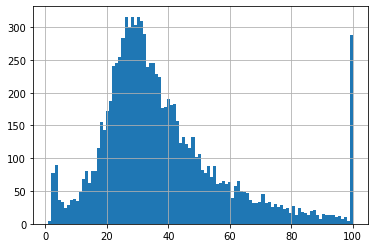

In [7]:
df_train.Pawpularity.hist(bins=100)

<AxesSubplot:>

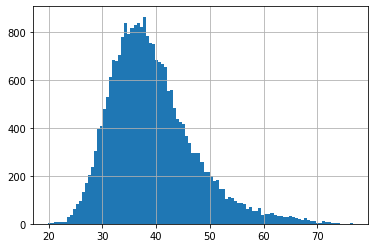

In [8]:
df_exdata.Pawpularity.hist(bins=100)

# Define model

In [9]:
class Model(nn.Module):
    def __init__(self, model_name, pretrained=True):
        super().__init__()
        self.model = timm.create_model(model_name, pretrained=pretrained, in_chans=3)
        self.n_features = self.model.classifier.in_features
        self.model.classifier = nn.Linear(self.n_features, 1)

    def forward(self, x):
        output = self.model(x)
        return output

class SwinModel(nn.Module):
    def __init__(self, model_name, pretrained=True):
        super().__init__()
        self.model   = timm.create_model(model_name, pretrained=pretrained, num_classes=0, in_chans=3)
        num_features = self.model.num_features
        self.linear  = nn.Linear(num_features, 1)

    def forward(self, x):
        x = self.model(x)
        output = self.linear(x)
        return output

In [10]:
class PetFinderDataset(Dataset):
    def __init__(self, df_img, transforms=None, train=True, output_label=True):
        super().__init__()
        self.df_img  = df_img.reset_index(drop=True).copy()
        self.transforms   = transforms
        self.train        = train
        self.output_label = output_label
        
    def __len__(self):
        return self.df_img.shape[0]
    
    def __getitem__(self, index: int):
        img = get_img(self.df_img.loc[index].path)
        if CFG["loss"] == "binary":
            y = torch.from_numpy(np.array(self.df_img.loc[index].Pawclass))
        else:
            y = torch.from_numpy(np.array(self.df_img.loc[index].Pawpularity))
        if self.transforms:
            if self.train:
                img = self.transforms(image=img)['image']
            else:
                h, w, _ = img.shape
                trans = self.transforms(h, w)
                img   = trans(image=img)['image']
        if self.output_label:
            return img, y
        return img

In [11]:
def get_train_transforms():
    return Compose([
        Resize(CFG['size'], CFG['size'], p=1.0),
        HorizontalFlip(p=0.5),
        HueSaturationValue(hue_shift_limit=0.2, sat_shift_limit=0.2, val_shift_limit=0.2, p=0.5),
        RandomBrightnessContrast(brightness_limit=(-0.1,0.1), contrast_limit=(-0.1, 0.1), p=0.5),
        Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], max_pixel_value=255.0, p=1.0),
        ToTensorV2(p=1.0)], p=1.0)

#https://www.kaggle.com/heyytanay/definitive-pytorch-trainer-mixup-kfolds-w-b
def mixup_augmentation(x:torch.Tensor, y:torch.Tensor, alpha:float = 1.0):
    """
    Function which performs Mixup augmentation
    """
    assert alpha > 0, "Alpha must be greater than 0"
    assert x.shape[0] > 1, "Need more than 1 sample to apply mixup"

    lam = np.random.beta(alpha, alpha)
    rand_idx = torch.randperm(x.shape[0])
    mixed_x  = lam * x + (1 - lam) * x[rand_idx, :]
    target_a, target_b = y, y[rand_idx]
    return mixed_x, target_a, target_b, lam

def prepare_dataloader(train):
    train_ds = PetFinderDataset(train, transforms=get_train_transforms())
    train_loader = torch.utils.data.DataLoader(train_ds,
                                               batch_size=CFG['batch_size'],
                                               drop_last=False,
                                               pin_memory=False,
                                               shuffle=True,
                                               num_workers=CFG['num_workers'])
    return train_loader

In [12]:
def train_one_epoch(epoch, model, loss_fn, optimizer, train_loader, device, scheduler=None, schd_batch_update=False):
    model.train()

    t = time.time()
    running_loss  = None
    mean_loss     = 0
    img_preds_all = []
    img_truth_all = []

    pbar = tqdm(enumerate(train_loader), total=len(train_loader))
    for step, (imgs, targets) in pbar:
        imgs    = imgs.to(device).float()
        targets = targets.reshape(-1,1).to(device).float()

        if torch.rand(1)[0] < CFG["mixup_ratio"]:
            mix_img, tar_a, tar_b, lam = mixup_augmentation(imgs, targets, alpha=0.5)
            with autocast():
                img_preds = model(mix_img)
                # Mixup loss calculation
                loss_a = loss_fn(img_preds, tar_a)
                loss_b = loss_fn(img_preds, tar_b)
                loss = (loss_a * lam + (1 - lam) * loss_b) / CFG['accum_iter']
        else:
            with autocast():
                img_preds = model(imgs)
                loss = loss_fn(img_preds, targets) / CFG['accum_iter']
        scaler.scale(loss).backward()

        img_preds_all += [img_preds.detach().cpu().numpy()]
        img_truth_all += [targets.detach().cpu().numpy()]
        
        if running_loss is None:
            running_loss = loss.item()
        else:
            running_loss = running_loss * .99 + loss.item() * .01
        mean_loss += loss.item()

        if ((step + 1) %  CFG['accum_iter'] == 0) or ((step + 1) == len(train_loader)):
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad() 
            if scheduler is not None and schd_batch_update:
                scheduler.step()

        if ((step + 1) % CFG['verbose_step'] == 0) or ((step + 1) == len(train_loader)):
            description = f'epoch {epoch} loss: {running_loss:.4f}'
            pbar.set_description(description)
    
    if CFG["loss"] == "binary":
        img_preds_all = (sigmoid(np.concatenate(img_preds_all))*100).astype(int)
        img_truth_all = (np.concatenate(img_truth_all)*100).astype(int)
    else:
        img_preds_all = np.concatenate(img_preds_all)
        img_truth_all = np.concatenate(img_truth_all)
    rmse = np.sqrt(mean_squared_error(img_preds_all, img_truth_all))
    print('Training rmse = {:.6f}'.format(rmse))

    if scheduler is not None and not schd_batch_update:
        scheduler.step()
    return rmse, mean_loss/len(train_loader), [img_preds_all, img_truth_all]

In [13]:
def sgd_optimizer(model, lr, momentum, weight_decay):
    params = []
    for key, value in model.named_parameters():
        if not value.requires_grad:
            continue
        apply_weight_decay = weight_decay
        apply_lr = lr
        if 'bias' in key or 'bn' in key:
            apply_weight_decay = 0
        if 'bias' in key:
            apply_lr = 2 * lr       # Just a Caffe-style common practice. Made no difference.
        params += [{'params': [value], 'lr': apply_lr, 'weight_decay': apply_weight_decay}]
    optimizer = torch.optim.SGD(params, lr, momentum=momentum)
    return optimizer

class RMSELoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.mse = nn.MSELoss()
        
    def forward(self, yhat, y):
        return torch.sqrt(self.mse(yhat, y))

# Run training

In [14]:
not_improved_cnt = 0
best_rmse  = 999
best_epoch = 0
histories  = {}
device     = torch.device(CFG['device'])

if -1 < CFG["model"].find("swin"):
    model = SwinModel(CFG["model"], pretrained=True)
else:
    model = Model(CFG["model"], pretrained=True)
model.to(device)
scaler    = GradScaler()
#optimizer = sgd_optimizer(model, CFG['lr'], CFG['momentum'], CFG['weight_decay'])
#scheduler = CosineAnnealingLR(optimizer=optimizer, T_max=CFG['T_0'])
optimizer = RAdam(model.parameters(), lr=CFG['lr'], weight_decay=CFG['weight_decay'])
scheduler = None
if CFG["loss"] == "binary":
    loss  = nn.BCEWithLogitsLoss().to(device)
else:
    loss  = RMSELoss().to(device)

for epoch in range(CFG['epochs']):
    print('Training with epoch {} started.'.format(epoch))
    
    target = "Pawclass" if CFG["loss"] == "binary" else "Pawpularity"
    # Ref: https://www.kaggle.com/c/tensorflow-speech-recognition-challenge/discussion/47722
    if CFG["train_type"] == 1:
        n     = int(df_train.shape[0] * random.uniform(0.2, 0.35))
        train = pd.concat([df_train[["path",target]],
                           df_exdata.sample(n)[["path",target]]]).reset_index(drop=True)
        print(f"Data size is {train.shape[0]} including {train.shape[0]-df_train.shape[0]} pseudo labeled data.")
    else:
        train = df_exdata.copy()
        print(f"Data size is {train.shape[0]}. All of data is pseudo labeled data.")
    train_loader = prepare_dataloader(train)
    
    rmse, train_loss, hist = train_one_epoch(epoch, model, loss, optimizer, train_loader, device, scheduler=scheduler, schd_batch_update=False)
    histories[epoch] = [rmse, train_loss, hist]

    torch.save(model.state_dict(), f"{CFG['output_path']}{CFG['save_name']}_{epoch}.pt")

del model, optimizer, train_loader, scaler
torch.cuda.empty_cache()

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-effv2-weights/tf_efficientnetv2_s_21k-6337ad01.pth" to /root/.cache/torch/hub/checkpoints/tf_efficientnetv2_s_21k-6337ad01.pth


Training with epoch 0 started.
Data size is 25000. All of data is pseudo labeled data.


epoch 0 loss: 0.3389: 100%|██████████| 782/782 [04:45<00:00,  2.74it/s]


Training rmse = 12.145674
Training with epoch 1 started.
Data size is 25000. All of data is pseudo labeled data.


epoch 1 loss: 0.3350: 100%|██████████| 782/782 [04:31<00:00,  2.88it/s]


Training rmse = 8.142599
Training with epoch 2 started.
Data size is 25000. All of data is pseudo labeled data.


epoch 2 loss: 0.3329: 100%|██████████| 782/782 [04:32<00:00,  2.87it/s]


Training rmse = 6.601106
Training with epoch 3 started.
Data size is 25000. All of data is pseudo labeled data.


epoch 3 loss: 0.3318: 100%|██████████| 782/782 [04:35<00:00,  2.84it/s]


Training rmse = 5.677905
Training with epoch 4 started.
Data size is 25000. All of data is pseudo labeled data.


epoch 4 loss: 0.3307: 100%|██████████| 782/782 [04:36<00:00,  2.82it/s]


Training rmse = 4.972512
Training with epoch 5 started.
Data size is 25000. All of data is pseudo labeled data.


epoch 5 loss: 0.3305: 100%|██████████| 782/782 [04:40<00:00,  2.79it/s]


Training rmse = 4.420380
Training with epoch 6 started.
Data size is 25000. All of data is pseudo labeled data.


epoch 6 loss: 0.3301: 100%|██████████| 782/782 [04:36<00:00,  2.83it/s]


Training rmse = 3.994902
Training with epoch 7 started.
Data size is 25000. All of data is pseudo labeled data.


epoch 7 loss: 0.3300: 100%|██████████| 782/782 [04:35<00:00,  2.84it/s]


Training rmse = 3.655418
Training with epoch 8 started.
Data size is 25000. All of data is pseudo labeled data.


epoch 8 loss: 0.3296: 100%|██████████| 782/782 [04:37<00:00,  2.82it/s]


Training rmse = 3.359178
Training with epoch 9 started.
Data size is 25000. All of data is pseudo labeled data.


epoch 9 loss: 0.3293: 100%|██████████| 782/782 [04:37<00:00,  2.81it/s]


Training rmse = 3.159665


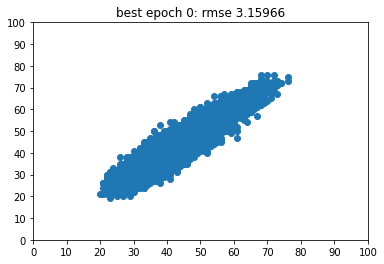

In [15]:
rmse, _, (pred, gt) = histories[epoch]
plt.scatter(x=pred, y=gt)
plt.xticks(np.arange(0,101,10))
plt.yticks(np.arange(0,101,10))
plt.title(f"best epoch {best_epoch}: rmse {round(rmse,5)}")
plt.show()